In [1]:
##########################################
#Script to run inference on trained model#
#Maintainer: Christopher Chan            #
#Version: 0.0.1                          #
#Date: 2022-04-13                        #
##########################################

import os
import sys
import torch
import random
import re
import tqdm
from dataloader import BuildingDataset
import numpy as np
import torchvision.models as models
import segmentation_models_pytorch as smp
import torch.nn as nn
import matplotlib
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import pandas as pd
from torch.utils.data import DataLoader
from Networks import Five_UNet, Four_UNet
from torchvision import transforms
from PIL import Image
from scipy import ndimage
from torch.utils.data import DataLoader

%matplotlib inline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
data_path = os.path.abspath("/home/chris/Dropbox/HOTOSM/SAMPLE/")
Four_UNet = Four_UNet()

print(f"Training on device {device}.")

Training on device cuda.


In [2]:
TestIMG_ls = []
TestLBL_ls = []

for root, dirs, filename in os.walk(os.path.join(data_path, "Test_15cm", "IMG")):
    for i in filename:
        #if i.startswith("KBY15_IMG"):
            TestIMG_ls.append(root + "/" + i)

for i in TestIMG_ls:
    i = re.sub("IMG", "LBL", i, count = 2)
    TestLBL_ls.append(i)

Test = BuildingDataset(png_dir = TestIMG_ls,
                       lbl_dir = TestLBL_ls)

assert len(Test.png_dir) == len(Test.lbl_dir)

print("Concatenated TESTING images: {0} and labels pair: {0} :".format(len(Test.png_dir)))
for x, y in zip(Test.png_dir, Test.lbl_dir):
    print(f"Image: {x}", f"Label: {y}")


Concatenated TESTING images: 611 and labels pair: 611 :
Image: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/IMG/DZK15_IMG_8037-3933.png Label: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/LBL/DZK15_LBL_8037-3933.png
Image: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/IMG/KBY15_IMG_31293-24624.png Label: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/LBL/KBY15_LBL_31293-24624.png
Image: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/IMG/DZK15_IMG_5643-5301.png Label: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/LBL/DZK15_LBL_5643-5301.png
Image: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/IMG/DZK15_IMG_7182-3249.png Label: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/LBL/DZK15_LBL_7182-3249.png
Image: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/IMG/DZK15_IMG_1881-13680.png Label: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/LBL/DZK15_LBL_1881-13680.png
Image: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/IMG/KBY15_IMG_10260-3249.png Label: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/LBL/KBY15_LBL_102

In [3]:
#Net = smp.Unet(encoder_name = 'efficientnet-b1', encoder_depth = 5, encoder_weights = None, decoder_use_batchnorm = True, decoder_channels = (256, 128, 64, 32, 16), decoder_attention_type = None, in_channels = 3, classes = 1, activation = "sigmoid", aux_params = None)
#qubvel_weights = os.path.abspath("/home/chris/Dropbox/HOTOSM/qubvel_UNet/weights/stage3/effb1-f0/checkpoints/best.pth")
#qubvel_weights = torch.load(qubvel_weights, map_location = device)
#Net.load_state_dict(qubvel_weights["state_dict"])

Net = smp.Unet(encoder_name = 'efficientnet-b1', encoder_depth = 4, encoder_weights = None, decoder_use_batchnorm = True, decoder_channels=(128, 64, 32, 16), decoder_attention_type = None, in_channels= 3 , classes = 1, activation = "sigmoid", aux_params = None)
weights = os.path.abspath(os.path.join(data_path, "best_weights", "BASE_15cmALL", "20713:5094_256oc1_EB1-Unet-IMN_lr1e-3_wd1e-5_b32_ep500_BCE_RLRONPLATEAU(min1e-8)_iter_324647.pth"))
xp_name = os.path.basename(weights)
weights = torch.load(weights, map_location = device)
Net.load_state_dict(weights["Model:"])

#Net = Four_UNet()
#weights = torch.load(weights, map_location = device)
#Net.load_state_dict(weights["Model:"])

Net = Net.to(device = device)

n_params = [p.numel() for p in Net.parameters() if p.requires_grad == True]

print(Net)
print('Trainable parameters in current model:', n_params)

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_

Text(0.5, 1.0, 'LBL')

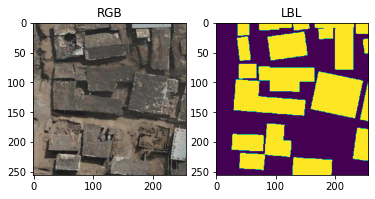

In [12]:
# plot a sample
test_pair = random.choice(Test)

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
RGB = plt.imshow(test_pair[0].detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('RGB')

ax = fig.add_subplot(1, 2, 2)
LBL = plt.imshow(test_pair[1].detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('LBL')

torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
Minimum: 3.952756287617376e-06, Maximum: 0.006445793434977531, Mean: 0.0019988110288977623, St dev: 0.00135920406319201
True Positive = 110.29412078857422, True Negative = 21193.1015625 False Negative = 5.898039817810059, False Positive = 44226.703125
Precision = 0.0024876317474991083, Recall = 0.9492388963699341, Specificity = 0.3239554464817047 Overall Accuracy = 0.3250640332698822, Intersection-over-Union = 0.002487300895154476


Text(0.5, 1.0, 'Binary Segmentation')

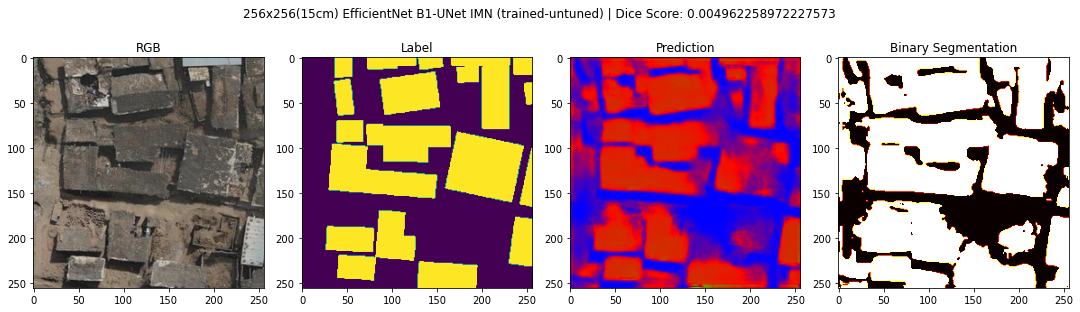

In [13]:
Net.eval()

# Testing a single pair of Image and Label

img, lbl = test_pair[0], test_pair[1]
img = img.to(device = device)
lbl = lbl.to(device = device)
print(img.shape, lbl.shape)

with torch.no_grad():
    prediction = Net(img.unsqueeze(0))
    prediction = prediction.squeeze(0)
    
    print("Minimum: {0}, Maximum: {1}, Mean: {2}, St dev: {3}".format(prediction.min(), prediction.max(), prediction.mean(), prediction.std()))

    pred_BOOL = (prediction > 0.001).to(torch.float32)

    # Dice Loss
    dice_pred = pred_BOOL.sum(dim = [0, 1, 2])
    dice_lbl = lbl.sum(dim = [0, 1, 2])
    dice_score = 0
    dice_score += (2 * (pred_BOOL * lbl).sum(dim = [0, 1, 2]) + 1e-8) / (dice_pred + dice_lbl + 1e-8)
    dice_score = dice_score.detach().cpu().numpy()

    # 1st order statistics
    TP = (pred_BOOL * lbl).sum(dim = [0, 1, 2])
    TN = ((1 - pred_BOOL) * (1 - lbl)).sum(dim = [0, 1, 2])
    FN = ((1 - pred_BOOL) * lbl).sum(dim = [0, 1, 2])
    FP = (pred_BOOL * (1 - lbl)).sum(dim = [0, 1, 2])

    # 2nd order statistics
    Precision = (TP / (TP + FP))
    Recall = (TP / (TP + FN)) #True Positive Rate / Sensitivity
    Specificity = (TN / (FP + TN)) #True Negative Rate
    OA = ((TP + TN) / (TP + TN + FP + FN))
    IoU = (TP / (TP + FN + FP))

print("True Positive = {0}, True Negative = {1} False Negative = {2}, False Positive = {3}".format(TP, TN, FN, FP))
print("Precision = {0}, Recall = {1}, Specificity = {2} Overall Accuracy = {3}, Intersection-over-Union = {4}".format(Precision, Recall, Specificity, OA, IoU))

# Plotting the RGB, Prediction, and Confidence
fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(1, 4, 1)
fig.tight_layout(w_pad = 3)
fig.suptitle("256x256(15cm) EfficientNet B1-UNet IMN (trained-untuned) | Dice Score: {0}".format(dice_score))
RGB = plt.imshow(test_pair[0].detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('RGB')

ax = fig.add_subplot(1, 4, 2)
PILlbl = lbl.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILlbl)
ax.set_title('Label')

ax = fig.add_subplot(1, 4, 3)
PILpred = prediction.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILpred, cmap = "brg")
#plt.colorbar(boundaries = np.arange(0, 1.0, 0.1), ticks = np.arange(0, 1.0, 0.1),
#             orientation = "horizontal")
ax.set_title('Prediction')

ax = fig.add_subplot(1, 4, 4)
PILbin = pred_BOOL.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILbin, cmap = "hot")
ax.set_title('Binary Segmentation')

In [14]:
# Loading testing batch
test_loader = DataLoader(Test, batch_size = 1, shuffle = True)

idx = []
Dice_ls = []
TP_ls = []
TN_ls = []
FN_ls = []
FP_ls = []
Precision_ls = []
Recall_ls = []
Specificity_ls = []
OA_ls = []
IoU_ls = []

for i, (img, lbl) in tqdm(enumerate(test_loader), total = len(test_loader)):
    img = img.to(device = device)
    lbl = lbl.to(device = device)

    with torch.no_grad():
        prediction = Net(img)
        prediction = prediction.squeeze(0)
        lbl = lbl.squeeze(0)

        pred_BOOL = (prediction > 0.5).to(torch.float32)

        # Dice Loss
 
        dice_pred = pred_BOOL.sum(dim = [0, 1, 2])
        dice_lbl = lbl.sum(dim = [0, 1, 2])
        dice_score = 0
        dice_score += (2 * (pred_BOOL * lbl).sum(dim = [0, 1, 2]) + 1e-8) / (dice_pred + dice_lbl + 1e-8)
        dice_score = dice_score.detach().cpu().numpy()
        Dice_ls.append(dice_score)

       # 1st order statistics
        TP = (pred_BOOL * lbl).sum(dim = [0, 1, 2])
        TN = ((1 - pred_BOOL) * (1 - lbl)).sum(dim = [0, 1, 2])
        FN = ((1 - pred_BOOL) * lbl).sum(dim = [0, 1, 2])
        FP = (pred_BOOL * (1 - lbl)).sum(dim = [0, 1, 2])

        # 2nd order statistics
        Precision = (TP / (TP + FP))
        Recall = (TP / (TP + FN)) #True Positive Rate / Sensitivity
        Specificity = (TN / (FP + TN)) #True Negative Rate
        OA = ((TP + TN) /(TP + TN + FP + FN))
        IoU = (TP / (TP + FN + FP))

        TP = TP.detach().cpu().numpy()
        TN = TN.detach().cpu().numpy()
        FN = FN.detach().cpu().numpy()
        FP = FP.detach().cpu().numpy()
        Precision = Precision.detach().cpu().numpy()
        Recall = Recall.detach().cpu().numpy()
        Specificity = Specificity.detach().cpu().numpy()
        OA = OA.detach().cpu().numpy()
        IoU = IoU.detach().cpu().numpy()
        
        idx.append(i)
        TP_ls.append(TP)
        TN_ls.append(TN)
        FN_ls.append(FN)
        FP_ls.append(FP)
        Precision_ls.append(Precision)
        Recall_ls.append(Recall)
        Specificity_ls.append(Specificity)
        OA_ls.append(OA)
        IoU_ls.append(IoU)

df = {"id": idx,
      "Dice_score": Dice_ls,
      "True_Positive": TP_ls,
      "True_Negative": TN_ls,
      "False_Negative": FN_ls,
      "False_Positive": FP_ls,
      "Precision": Precision_ls,
      "Recall": Recall_ls,
      "Specificity": Specificity_ls,
      "Overall Accuracy": OA_ls,
      "IoU": IoU_ls}
      
results_csv = pd.DataFrame(df)
print(xp_name, "mean Dice Score = {0}, mean Precision = {1}, mean Recall = {2}, mean Specificity = {3}, mean OA = {4}, mean IoU = {5}".format(np.mean(Dice_ls), np.mean(Precision_ls), np.mean(Recall_ls), np.mean(Specificity_ls), np.mean(OA_ls), np.mean(IoU_ls)))

# ROC curve and AUC
FPR_diam_diff = (1 - Specificity_ls[0]) - (1 - Specificity_ls[-1])
Recall_avg = (Recall_ls[0] + Recall_ls[-1]) / 2
AUC_diam = (FPR_diam_diff * Recall_avg).sum()

plt.plot(FPR_diam_diff, Recall_avg, label = f"diameter baseline, AUC = {AUC_diam:.3f}")

TypeError: 'module' object is not callable